In [2]:
from pymongo import MongoClient
import pandas as pd 
import re
from collections import Counter
from konlpy.tag import Okt
from mecab import MeCab
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # word embedding

# 네트워크 연결 규칙 : protocol://ip:port/path 
client = MongoClient('mongodb://192.168.0.50:27017/')

db_name = client["DB_SGMN"]
collection = db_name["COL_SCRAPPING_TOSS_COMMENT_HISTORY"]

In [3]:
find_data = collection.find()
data_list = list(find_data)

In [4]:
df_data = pd.DataFrame(data_list)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251836 entries, 0 to 251835
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   _id         251836 non-null  object        
 1   COMMENT     251836 non-null  object        
 2   CREATED_AT  251836 non-null  datetime64[ns]
 3   DATE        251836 non-null  object        
 4   DATETIME    251836 non-null  object        
 5   SYMBOL      251836 non-null  object        
 6   UPDATED_AT  251836 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 13.4+ MB


In [5]:
df_data[:50000].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   _id         50000 non-null  object        
 1   COMMENT     50000 non-null  object        
 2   CREATED_AT  50000 non-null  datetime64[ns]
 3   DATE        50000 non-null  object        
 4   DATETIME    50000 non-null  object        
 5   SYMBOL      50000 non-null  object        
 6   UPDATED_AT  50000 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 2.7+ MB


In [6]:
# df_data[:50000].to_csv('output.csv', index=False)  # index=False로 인덱스 열 제외

In [7]:
mecab_inst = MeCab()

In [8]:
# 주차 계산을 위한 함수 정의
def get_week(date_str):
    # 정규 표현식으로 연도와 월, 일을 추출
    match = re.match(r'(\d{4})-(\d{2})-(\d{2})', date_str)
    if match:
        year, month, day = map(int, match.groups())
        # 날짜 객체 생성
        date = pd.Timestamp(year=year, month=month, day=day)
        # ISO 주차 반환
        return date.isocalendar()[1]  # 주차
    return None


In [16]:
# DATE 열에서 주차 계산
df_data['WEEK'] = df_data['DATE'].apply(get_week)
df_data['WEEK'].unique()
# # 주차별로 그룹화하여 집계 (예: VALUE의 합계)
# weekly_data = df_data.groupby(['WEEK']).agg({'COMMENT': ' '.join}).reset_index()

# # 결과 출력
# print(weekly_data)

array([47, 49, 50, 51, 52])

In [35]:
stopwords = ['건가요','가즈']   
ngramrange = (1,3)

[(611.8202610047656, '테슬라'), (431.9746960001819, '엔비디아'), (364.76516068212453, '가즈'), (359.84212288142095, '오늘'), (264.727124583064, '달러'), (257.65101779544386, '주식'), (209.24963898363973, '고점'), (207.5542428964945, '추매'), (184.41221439271467, '이거'), (179.34178702867183, '수익')]


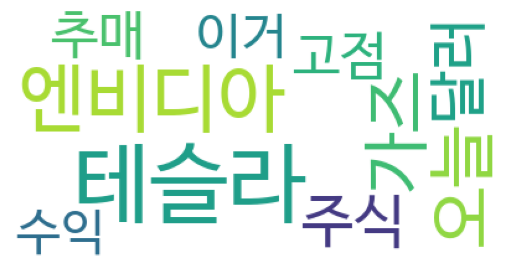

In [34]:
week = 49
df_week = df_data[df_data['WEEK'] == week]['COMMENT']
string_nouns = []
for text in df_week: 
    nouns_text = mecab_inst.nouns(text)
    filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]
    modify_nouns = [noun if noun != '엔비' else '엔비디아' for noun in filtered_nouns]
    modify_nouns2 = [noun if noun != '비디아' else '엔비디아' for noun in modify_nouns]
    string_nouns.append(' '.join(modify_nouns2))  # join() 메서드 사용
    
tfidfvectorizer = TfidfVectorizer(
    stop_words=stopwords, 
    ngram_range=ngramrange)
tfidfvectorizer.fit(string_nouns) # 학습
result_vectors = tfidfvectorizer.transform(string_nouns) 
tfidf_scores = result_vectors.toarray().sum(axis=0)
tfidf_rank_10 = sorted(zip(tfidf_scores, tfidfvectorizer.get_feature_names_out()), reverse=True)[:10]
print(tfidf_rank_10)
counter_dict = { word : score for score, word in tfidf_rank_10}
wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
wordcloud_instance.generate_from_frequencies(counter_dict) 
plt.imshow(wordcloud_instance)
plt.axis('off')
plt.show()

In [25]:
result_vectors.toarray().shape, tfidfvectorizer.get_feature_names_out().shape


((323, 2065), (2065,))

In [26]:
tfidf_scores = result_vectors.toarray().sum(axis=0)

In [27]:
tfidf_rank_10 = sorted(zip(tfidf_scores, tfidfvectorizer.get_feature_names_out()), reverse=True)[:10]
tfidf_rank_10

[(7.871902050428228, '애플'),
 (5.166077273038156, '아처'),
 (3.938504286246629, '진입'),
 (3.3402095618421175, '추매'),
 (3.3155756270146606, '조비'),
 (3.115684886588695, '수익'),
 (3.0578077726424615, '평단'),
 (2.684816138267277, '달러'),
 (2.6251594038632176, '비중'),
 (2.623336723207134, '공매도')]

[(7.871902050428228, '애플'), (5.166077273038156, '아처'), (3.938504286246629, '진입'), (3.3402095618421175, '추매'), (3.3155756270146606, '조비'), (3.115684886588695, '수익'), (3.0578077726424615, '평단'), (2.684816138267277, '달러'), (2.6251594038632176, '비중'), (2.623336723207134, '공매도')]


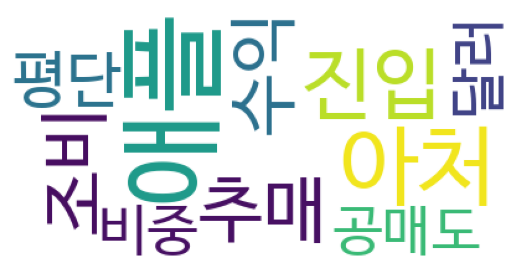

[(610.7769553569423, '테슬라'), (364.66808922299623, '가즈'), (359.64015350196183, '오늘'), (283.0475488444334, '엔비'), (264.68983399707895, '달러'), (257.2857945079452, '주식'), (209.21147756349797, '고점'), (207.54046338317613, '추매'), (184.4112718889778, '이거'), (179.094866711659, '수익')]


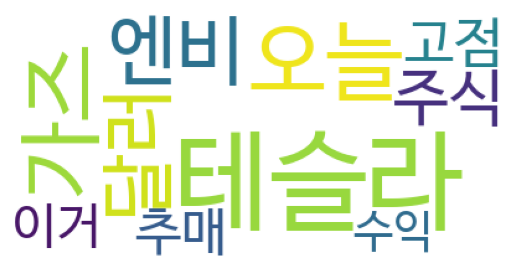

KeyboardInterrupt: 

In [29]:
for week in df_data['WEEK'].unique():
    df_week = df_data[df_data['WEEK'] == week]['COMMENT']
    string_nouns = []
    for text in df_week: 
        nouns_text = mecab_inst.nouns(text)
        filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]
        modify_nouns = [noun if noun != '엔비' else '엔비디아' for noun in filtered_nouns]
        string_nouns.append(' '.join(filtered_nouns))  # join() 메서드 사용
        
    tfidfvectorizer = TfidfVectorizer(
        stop_words=stopwords, 
        ngram_range=ngramrange)
    tfidfvectorizer.fit(string_nouns) # 학습
    result_vectors = tfidfvectorizer.transform(string_nouns) 
    tfidf_scores = result_vectors.toarray().sum(axis=0)
    tfidf_rank_10 = sorted(zip(tfidf_scores, tfidfvectorizer.get_feature_names_out()), reverse=True)[:10]
    print(tfidf_rank_10)

    counter_dict = { word : score for score, word in tfidf_rank_10}

    wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
    wordcloud_instance.generate_from_frequencies(counter_dict) 

    plt.imshow(wordcloud_instance)
    plt.axis('off')
    plt.show()

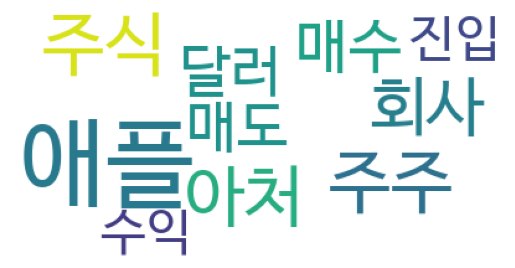

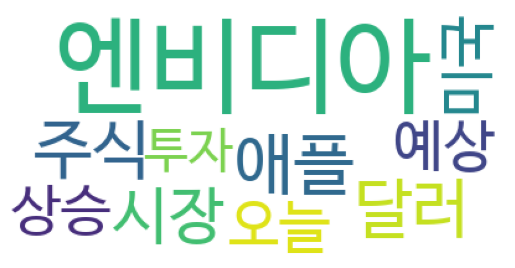

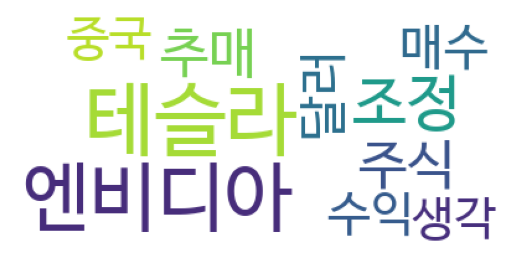

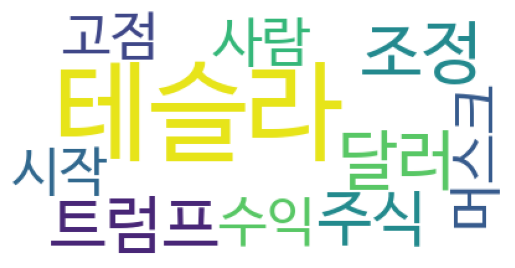

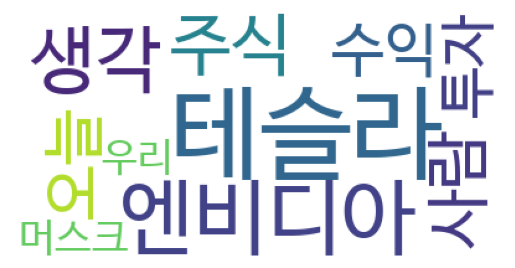

In [10]:
for text in weekly_data['COMMENT'].values:
    nouns_text = mecab_inst.nouns(text[:60000])
    filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]
    
    counter_text_splits = Counter(filtered_nouns)
    # '엔비'와 '비디아'의 count를 합쳐서 '엔비디아'에 저장
    if '엔비' in counter_text_splits and '비디아' in counter_text_splits:
        combined_count = counter_text_splits['엔비'] + counter_text_splits['비디아']
        counter_text_splits['엔비디아'] = combined_count

        # '엔비'와 '비디아'는 이제 삭제 (선택 사항)
        del counter_text_splits['엔비']
        del counter_text_splits['비디아']

    counter_dict = dict(counter_text_splits.most_common()[:10])

    wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
    wordcloud_instance.generate_from_frequencies(counter_dict) 

    plt.imshow(wordcloud_instance)
    plt.axis('off')
    plt.show()


In [11]:
def run_wordcloud(date_col_name, comment_col_name):
    df_data['WEEK'] = df_data[date_col_name].apply(get_week)
    weekly_data = df_data.groupby(['WEEK']).agg({comment_col_name: ' '.join}).reset_index()
    print(weekly_data)

    for text in weekly_data[comment_col_name].values:
        nouns_text = mecab_inst.nouns(text[:60000])
        filtered_nouns = [noun for noun in nouns_text if len(noun) > 1]

        counter_text_splits = Counter(filtered_nouns)
        # '엔비'와 '비디아'의 count를 합쳐서 '엔비디아'에 저장
        if '엔비' in counter_text_splits and '비디아' in counter_text_splits:
            combined_count = counter_text_splits['엔비'] + counter_text_splits['비디아']
            counter_text_splits['엔비디아'] = combined_count

            # '엔비'와 '비디아'는 이제 삭제 (선택 사항)
            del counter_text_splits['엔비']
            del counter_text_splits['비디아']
        counter_dict = dict(counter_text_splits.most_common()[:10])

        wordcloud_instance = WordCloud(background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
        wordcloud_instance.generate_from_frequencies(counter_dict) 

        plt.imshow(wordcloud_instance)
        plt.axis('off')
        plt.show()


   WEEK                                            COMMENT
0    47  머선일이야 뭐냐 너..왜 희망 갖게하냐 몇개월 기다리다가 조금 올라서 뺏더니 잘 올...
1    49  계엄 실패 너무 아쉬운 사람 개추 👍👍👍 2024-12-04\n\n안녕하세요 존버꿀...
2    50  치매치료약 문열어주세요 현기증난단말이에요 하.. 14퍼 올랐는데 3만원밖에 안 넣어...
3    51  테슬라 흥행하면 꼭 자빠지네 브론즈 뱃지ㅣ단 듣보들이 차트분석을올린다?\n강력한 매...
4    52  오늘 진짜 궁금하네 ㅋㅋ 제가 올해 총 600 수익을 냈고\n지금 -330인데 팔아...


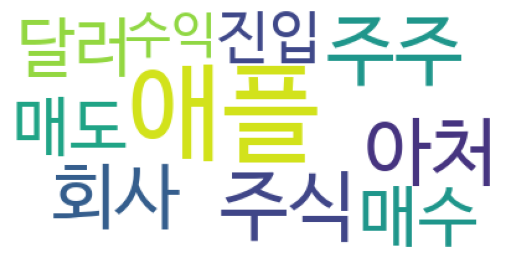

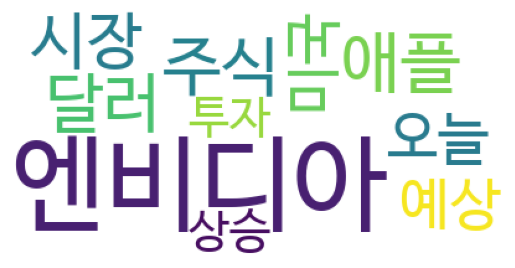

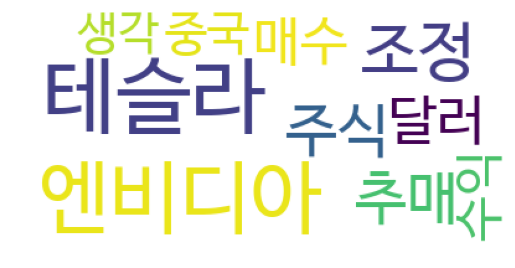

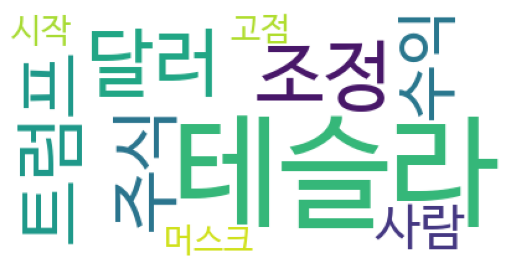

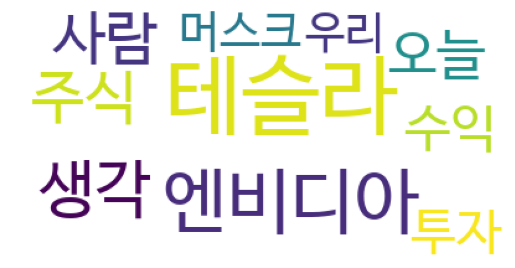

In [12]:
run_wordcloud('DATE','COMMENT')